In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from enhanced_utils import get_single_image_embedding, get_l1_score
from sys import path
from tqdm import tqdm
import chromadb

path.append('/Users/microwave/AIO_2024/Module_2/Image_retrieval/utils')
from query import plot_results

/Users/microwave/opt/anaconda3/lib/python3.9/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, m

In [4]:
ROOT = '/Users/microwave/AIO_2024/Module_2/Image_retrieval/data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))

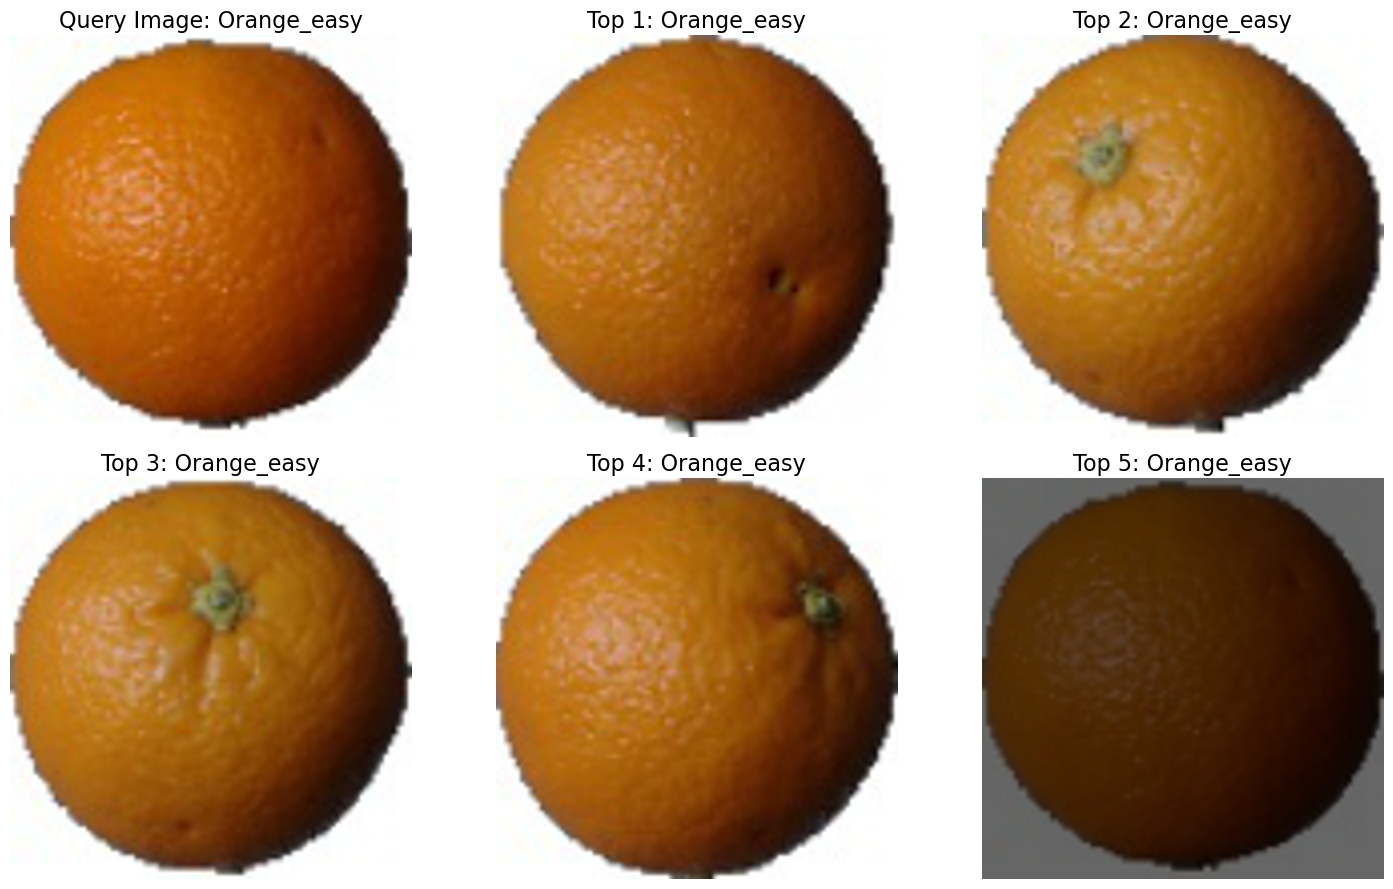

In [5]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

## Optimize image retrieval system using CLIP and vectorDB

In [6]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

data_path = f'{ROOT}/train'
files_path = get_files_path(path = data_path)

def add_embedding(collection,files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(embeddings=embeddings,ids=ids)

chroma_client = chromadb.Client()
l2_collection = chroma_client.get_or_create_collection(name="l2_collection",metadata={'HNSW_SPACE': "l2"})
add_embedding(collection=l2_collection, files_path=files_path)

def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )
    return results


595it [00:53, 11.06it/s]


In [10]:
def plot_results(image_path, files_path, results):
    # Open the query image
    query_image = Image.open(image_path)
    
    # Get the paths of the result images
    result_paths = [files_path[int(id.split('_')[1])] for id in results['ids'][0]]
    
    # Create a figure with 6 subplots (1 for query + 5 for results)
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Image Similarity Search Results', fontsize=16)

    # Plot the query image
    axs[0, 0].imshow(query_image)
    axs[0, 0].set_title('Query Image')
    axs[0, 0].axis('off')

    # Plot the result images
    for i, result_path in enumerate(result_paths):
        result_image = Image.open(result_path)
        row = (i + 1) // 3
        col = (i + 1) % 3
        axs[row, col].imshow(result_image)
        axs[row, col].set_title(f'Result {i+1}\nDistance: {results["distances"][0][i]:.4f}')
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

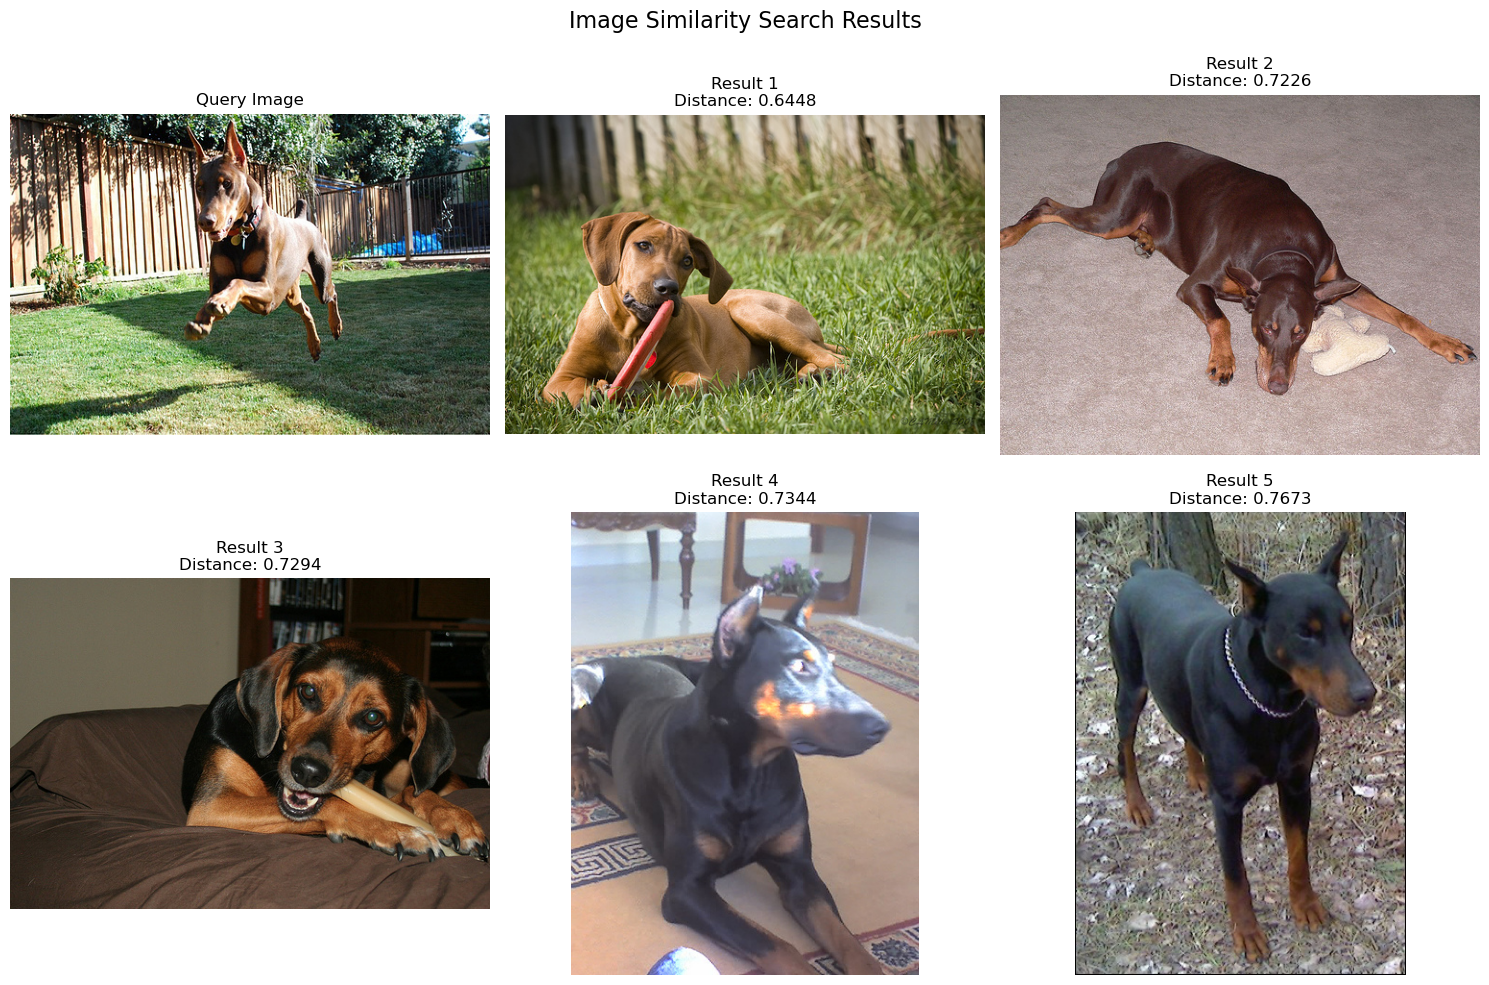

['/Users/microwave/AIO_2024/Module_2/Image_retrieval/data/train/Rhodesian_ridgeback/n02087394_21329.JPEG',
 '/Users/microwave/AIO_2024/Module_2/Image_retrieval/data/train/Doberman/n02107142_1596.JPEG',
 '/Users/microwave/AIO_2024/Module_2/Image_retrieval/data/train/Doberman/n02107142_49242.JPEG',
 '/Users/microwave/AIO_2024/Module_2/Image_retrieval/data/train/Doberman/n02107142_3654.JPEG',
 '/Users/microwave/AIO_2024/Module_2/Image_retrieval/data/train/Doberman/n02107142_32921.JPEG']

In [11]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[2]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)
plot_results(image_path=test_path, files_path=files_path, results=l2_results)